https://www.sec.gov/Archives/edgar/data/19617/000161577420003972/s124270_424b2.htm

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from dateutil import relativedelta
from scipy.stats import norm
import seaborn as sns
from business_duration import businessDuration

In [2]:
cd C:\Users\LIMDAESUN\Desktop\카이스트관련\UIUC\FE2\Project3

C:\Users\LIMDAESUN\Desktop\카이스트관련\UIUC\FE2\Project3


In [3]:
F = 1000
C = 33.75
SPX = pd.read_csv('SPX.csv',parse_dates=['Date']).set_index('Date')[['Adj Close']].rename(columns = {'Adj Close' : 'SPX'})
RTY = pd.read_csv('RTY.csv',parse_dates=['Date']).set_index('Date')[['Adj Close']].rename(columns = {'Adj Close' : 'RTY'})
NDX = pd.read_csv('NDX.csv',parse_dates=['Date']).set_index('Date')[['Adj Close']].rename(columns = {'Adj Close' : 'NDX'})

In [4]:
pricing_date = pd.datetime(2020,3,26)
Barrier = 0.7
imvol_SPX = np.array([[0.621, 0.512, 0.453, 0.417, 0.385, 0.364],          ################################
                      [0.431, 0.361, 0.334, 0.312, 0.291, 0.277]])         ###  Vol Surface of 3 assets  ## 
imvol_RTY = np.array([[0.429, 0.393, 0.384, 0.382, 0.369, 0.380],          ################################
                      [0.314, 0.300, 0.302, 0.315, 0.296, 0.310]])
imvol_NDX = np.array([[0.650, 0.510, 0.446, 0.406, 0.385, 0.368],
                      [0.445, 0.365, 0.331, 0.315, 0.298, 0.286]])
Maturity = pd.datetime(2021,9,30)
Div = np.array([0.0234,0.0170, 0.0119]).reshape(1,-1,1)
Review_Dates = [pd.datetime(2020,6,25), pd.datetime(2020,9,25),
                pd.datetime(2020,12,28), pd.datetime(2021,3,26),
                pd.datetime(2021,6,25), pd.datetime(2021,9,30)]
Discount_Data = pd.read_excel('Discount.xlsx', parse_dates=['Maturity Date'], index_col = 0)
Discount_Rate = np.exp(np.log(Discount_Data.Discount.resample('D').last()).interpolate(method = 'linear'))
initial_Discount = pd.Series([2 * Discount_Rate['2020-06-26'] - Discount_Rate['2020-06-27']], index = [Review_Dates[0]])
Discount_Rate = pd.concat([initial_Discount, Discount_Rate], axis = 0)

In [5]:
def Note_pricing(SPX,RTY,NDX,imvol_SPX, imvol_RTY, imvol_NDX,
                 pricing_date, Maturity, Review_Dates, Div,
                Discount_Rate, C, F=1000,simul_num = 3000,
                 Barrier = 0.7,Payoff_path_Result = False,
                 initial_Schange = 0, ewm_alpha = 0.04) :    
    
    Data = pd.concat([SPX, RTY, NDX], axis = 1)
    S1 , S2, S3 = SPX.SPX.loc[pricing_date] ,RTY.RTY.loc[pricing_date], NDX.NDX.loc[pricing_date]   ## initial Price ##
    
    Total_Businessday = int(businessDuration(pricing_date, pricing_date + relativedelta.relativedelta(years=2),unit = 'day')/2) 
    dt = 1/Total_Businessday
    date = pd.bdate_range(pricing_date, Maturity)
    
    Review_Time = []                                         ## 6 Review Time 
    for i in Review_Dates :                                  ##
        Review_Time.append(list(date).index(i))              ##
    Review_T = np.array(Review_Time[:-1])                    ## 5 Review T (Before Maturity)
    Review_mat = Review_Time[-1]                             ## Final Review Time (== Maturity)
    
    Discount = np.array(Discount_Rate.loc[Review_Dates]).reshape(-1,1,1)
    
    T = (Maturity - pricing_date).days/ Total_Businessday 
    r = -np.log(Discount_Rate.loc[Maturity])/T               ## r = -1/T ln(Discount)
    
    #############################################################################################################
    #### 5 Forward Vol Before Maturity (0~1, 1~2, 2~3, 3~4, 4~5),  {5~Maturity will be created at a later}   ####
    #############################################################################################################
    F_vol_SPX = np.sqrt((Review_T[1:]* imvol_SPX[:,:-1][:, 1:]**2 -imvol_SPX[:,:-1][:,:-1]**2 *Review_T[:-1])/
                        (Review_T[1:]-Review_T[:-1]))
    F_vol_SPX = np.concatenate([imvol_SPX[:,0:1], F_vol_SPX], axis = 1)

    F_vol_RTY = np.sqrt((Review_T[1:]* imvol_RTY[:,:-1][:, 1:]**2 -imvol_RTY[:,:-1][:,:-1]**2 *Review_T[:-1])/
                        (Review_T[1:]-Review_T[:-1]))
    F_vol_RTY = np.concatenate([imvol_RTY[:,0:1], F_vol_RTY], axis = 1)

    F_vol_NDX = np.sqrt((Review_T[1:]* imvol_NDX[:,:-1][:, 1:]**2 -imvol_NDX[:,:-1][:,:-1]**2 *Review_T[:-1])/
                        (Review_T[1:]-Review_T[:-1]))
    F_vol_NDX = np.concatenate([imvol_NDX[:,0:1], F_vol_NDX], axis = 1)    
    
    ret = np.log(Data).diff().iloc[1:]
    corr = ret.ewm(alpha = ewm_alpha).corr().loc[pricing_date]                        ## Exponantial Weight Corr Matrix 
    num_of_vol = np.concatenate([[Review_T[0]],Review_T[1:] - Review_T[:-1]])    ## Number Of Forward Date [date(T0~T1), date(T1~R2) ....]
    
    s_SPX07 = np.array([])
    s_RTY07 = np.array([])
    s_NDX07 = np.array([])
    s_SPX10 = np.array([])
    s_RTY10 = np.array([])
    s_NDX10 = np.array([])
    for i in range(len(num_of_vol)) :
        s_SPX07 = np.concatenate([s_SPX07,np.repeat(F_vol_SPX[0,i] , num_of_vol[i])])  ####################################################
        s_RTY07 = np.concatenate([s_RTY07,np.repeat(F_vol_RTY[0,i] , num_of_vol[i])])  ## They are Forward Vol Matrixs 0 to 5 Reivew day ##
        s_NDX07 = np.concatenate([s_NDX07,np.repeat(F_vol_NDX[0,i] , num_of_vol[i])])  ##                                                ## 
        s_SPX10 = np.concatenate([s_SPX07,np.repeat(F_vol_SPX[1,i] , num_of_vol[i])])  ##   5 Forward Vol are in Matrix as much as       ##           
        s_RTY10 = np.concatenate([s_RTY07,np.repeat(F_vol_RTY[1,i] , num_of_vol[i])])  ##                            the number of days  ##
        s_NDX10 = np.concatenate([s_NDX07,np.repeat(F_vol_NDX[1,i] , num_of_vol[i])])  ####################################################

    s_SPX07 = s_SPX07.reshape(-1,1,1)
    s_RTY07 = s_RTY07.reshape(-1,1,1)
    s_NDX07 = s_NDX07.reshape(-1,1,1)
    s_SPX10 = s_SPX10.reshape(-1,1,1)
    s_RTY10 = s_RTY10.reshape(-1,1,1)
    s_NDX10 = s_NDX10.reshape(-1,1,1)
                                                                    #######################################################
    vol07 = np.concatenate([s_SPX07, s_RTY07, s_NDX07], axis = 1)   ## axis0 = Time to 5 Review day , axis1 = Underlying ##
    vol10 = np.concatenate([s_SPX07, s_RTY07, s_NDX07], axis = 1)   ##      contents = Forward Vol                       ##
                                                                    #######################################################
    Barrier_array = np.array([S1,S2,S3]).reshape(1,-1,1) * Barrier
    
    e = np.random.multivariate_normal(np.repeat(0,3) , np.array(corr) , size = (Review_T[-1],simul_num)).transpose(0,2,1)
    S = np.array([S1,S2,S3]).reshape(1,-1,1) * (1+initial_Schange)
    cum_diffusion07 = (vol07 * np.sqrt(dt) * e).cumsum(0)
    cum_drift07 = ((r -Div - 0.5 * vol07**2) * dt * np.ones(e.shape)).cumsum(0)
    cum_diffusion10 = (vol10 * np.sqrt(dt) * e).cumsum(0)
    cum_drift10 = ((r -Div - 0.5 * vol10**2) * dt * np.ones(e.shape)).cumsum(0)       ###########################################
                                                                                      ### Simulated With ITM Vol and ATM Vol  ###
    S_path07 = S * np.exp(cum_drift07 + cum_diffusion07)                              ###########################################
    S_path07 = np.concatenate([S * np.ones((1,1,simul_num)) , S_path07], axis = 0)
    S_path10 = S * np.exp(cum_drift10 + cum_diffusion10)
    S_path10 = np.concatenate([S * np.ones((1,1,simul_num)) , S_path07], axis = 0)
    
    Barrier_mat = np.zeros((Review_Time[-1]+1, 3, simul_num))
    Barrier_mat[Review_Time,:,:] = Barrier_array * np.ones((1,3,simul_num))    
    
    AC_prob_07 = []                                            ######################################
    AC_prob_10 = []                                            ## Calculate two AC Probabilitis   ###
    for i in range(len(Review_T)) :                            ######################################
        AC_prob07 = ((S_path07[Review_T[0:i+1], :, :] > S).min(1).max(0)).sum()/ simul_num
        AC_prob10 = ((S_path10[Review_T[0:i+1], :, :] > S).min(1).max(0)).sum()/ simul_num
        AC_prob_07.append(AC_prob07)
        AC_prob_10.append(AC_prob10)   
    
    AC_P = np.concatenate([np.array(AC_prob_07).reshape(1,-1),                ###########################################################
                           np.array(AC_prob_10).reshape(1,-1)], axis = 0)     ### Average Two AC Probability then there are 5 AC Probs ##
    Weight07 = 1-AC_P.mean(0).reshape(1,-1)                                   ##                                                       ##
    W = np.concatenate([Weight07 , 1-Weight07], axis = 0)                     ## Determines F_IV07, F_IV10 weight based on AC_prob.    ##
                                                                              ###########################################################
    w_avg_F_vol_SPX = (F_vol_SPX * W).sum(0)
    w_avg_F_vol_RTY = (F_vol_RTY * W).sum(0)
    w_avg_F_vol_NDX = (F_vol_NDX * W).sum(0)
    
    s_SPX = np.array([])
    s_RTY = np.array([])
    s_NDX = np.array([])
    for i in range(len(num_of_vol)) :
        s_SPX = np.concatenate([s_SPX,np.repeat(w_avg_F_vol_SPX[i] , num_of_vol[i])])    ################################################    
        s_RTY = np.concatenate([s_RTY,np.repeat(w_avg_F_vol_RTY[i] , num_of_vol[i])])    ## Make Weight Average Forward Vol Matrix     ##
        s_NDX = np.concatenate([s_NDX,np.repeat(w_avg_F_vol_NDX[i] , num_of_vol[i])])    #################################################
    s_SPX = s_SPX.reshape(-1,1,1)
    s_RTY = s_RTY.reshape(-1,1,1)
    s_NDX = s_NDX.reshape(-1,1,1)
    vol = np.concatenate([s_SPX, s_RTY, s_NDX], axis = 1)
    
    last_fd_vol_SPX07 = ((imvol_SPX[0,-1] * Review_Time[-1] - imvol_SPX[0,-2] * Review_Time[-2])/    ####################################
                         (Review_Time[-1] - Review_Time[-2]))                                        ## There are F_IV T5 ~ T6         ## 
    last_fd_vol_RTY07 = ((imvol_RTY[0,-1] * Review_Time[-1] - imvol_RTY[0,-2] * Review_Time[-2])/    ####################################
                         (Review_Time[-1] - Review_Time[-2]))
    last_fd_vol_NDX07 = ((imvol_NDX[0,-1] * Review_Time[-1] - imvol_NDX[0,-2] * Review_Time[-2])/
                         (Review_Time[-1] - Review_Time[-2]))
    last_fd_vol_SPX10 = ((imvol_SPX[1,-1] * Review_Time[-1] - imvol_SPX[1,-2] * Review_Time[-2])/
                         (Review_Time[-1] - Review_Time[-2]))
    last_fd_vol_RTY10 = ((imvol_RTY[1,-1] * Review_Time[-1] - imvol_RTY[1,-2] * Review_Time[-2])/
                         (Review_Time[-1] - Review_Time[-2]))
    last_fd_vol_NDX10 = ((imvol_NDX[1,-1] * Review_Time[-1] - imvol_NDX[1,-2] * Review_Time[-2])/
                         (Review_Time[-1] - Review_Time[-2]))
    
    cum_diffusion = (vol * np.sqrt(dt) * e).cumsum(0)
    cum_drift = ((r -Div - 0.5 * vol**2) * dt * np.ones(e.shape)).cumsum(0)        #####################################################
    S_path = S * np.exp(cum_drift + cum_diffusion)                                 ## Simulate to 5 Review day with Weight Ave F Vol ###
    S_path = np.concatenate([S * np.ones((1,1,simul_num)) , S_path], axis = 0)     #####################################################
    S_ = S_path[-1,:,:]
    
    e_to_mat = np.random.multivariate_normal(np.repeat(0,3) , corr, size = (Review_Time[-1]-Review_Time[-2],simul_num)).transpose(0,2,1)
    last_fd_vol_07 = np.array([last_fd_vol_SPX07,last_fd_vol_RTY07,last_fd_vol_NDX07]).reshape(1,-1,1)
    last_fd_vol_10 = np.array([last_fd_vol_SPX10,last_fd_vol_RTY10,last_fd_vol_NDX10]).reshape(1,-1,1)

    ############################################################
    ## Simulate Stock path from T5 to T6 with 2 Forward Vol  ###
    ############################################################
    cum_diffusion_07 = (last_fd_vol_07 * np.sqrt(dt) * e_to_mat).cumsum(0)
    cum_diffusion_10 = (last_fd_vol_10 * np.sqrt(dt) * e_to_mat).cumsum(0)

    cum_drift_07 = ((r-Div - 0.5 * last_fd_vol_07**2)*dt * np.ones(e_to_mat.shape)).cumsum(0)
    cum_drift_10 = ((r-Div - 0.5 * last_fd_vol_10**2)*dt * np.ones(e_to_mat.shape)).cumsum(0)

    S_path07 = S_ * np.exp(cum_drift_07 + cum_diffusion_07)
    S_path10 = S_ * np.exp(cum_drift_10 + cum_diffusion_10)
    
    S_path_07 = np.concatenate([S_path , S_path07], axis= 0)
    S_path_10 = np.concatenate([S_path , S_path10], axis= 0)
    
    KI_prob_07 = ((S_path_07[Review_Time, :, :] < Barrier_mat[Review_Time,:,:]).max(1).max(0)).sum()/ simul_num
    KI_prob_10 = ((S_path_10[Review_Time, :, :] < Barrier_mat[Review_Time,:,:]).max(1).max(0)).sum()/ simul_num        
    KI_prob = 0.5 * KI_prob_07+ 0.5 * KI_prob_10               ###########################################
                                                               ## Estimate The mean KI Probability   #####
    w_10_mat = KI_prob                                         ###########################################
    w_07_mat = 1-KI_prob
    last_fd_vol = last_fd_vol_07 * w_07_mat + last_fd_vol_10 * w_10_mat

    #########################################################
    ### Complete the simulation from T5 to T6 and combine ###
    #########################################################
    cum_diffusion_last = (last_fd_vol * np.sqrt(dt) * e_to_mat).cumsum(0)
    cum_drift_last = ((r-Div - 0.5 * last_fd_vol**2) * np.ones(e_to_mat.shape) * dt).cumsum(0)
    
    S_path_last = S_ * np.exp(cum_drift_last + cum_diffusion_last)
    S_simul = np.concatenate([S_path, S_path_last], axis = 0)
    
    payoff = np.zeros((Review_Time[-1]+1, 1, simul_num))  ### Temp array to make payoff ###
    
    S_Review_date = S_simul[Review_T, : , :]              ### Stock Price at Review days before Maturity  ###
    ############################################################################
    ## There are three category at Review days [Autocall, Coupon, Non Coupon] ##
    ############################################################################
    Autocall_condition = (S_simul[Review_T,:,:]>=S).min(axis = 1).reshape(len(Review_T),1,simul_num).cumsum(0).cumsum(0) == 1
    Coupon_condition = (1-Autocall_condition) * (S_simul[Review_T, :, :] >= Barrier_mat[Review_T,:,:]).min(axis = 1).reshape(len(Review_T),1,simul_num)
    Non_coupon_condition = 1-Autocall_condition - Coupon_condition

    Not_Autocalled_condition = (Autocall_condition.max(0).reshape(1,1,-1) == 0)  ### Not Autocalled Before Maturity ###
    KI_event_once = (S_simul[Review_Time,:,:] < Barrier_mat[Review_Time,:,:]).max(1).max(0).reshape(1,1,-1) ## At least KI case ##
    Under_07_at_maturity = (S_simul[-1,:,:] < Barrier_mat[-1,:,:]).max(0).reshape(1,1,-1)
    Under_10_at_maturity = (S_simul[-1,:,:] < S_simul[0,:,:]).max(0).reshape(1,1,-1)

    #####################################################
    ## There are Four category of Not Autocalled Cases ##
    #####################################################
    Not_AC_and_KI_event_under10 = Not_Autocalled_condition * KI_event_once * Under_10_at_maturity 
    Not_AC_and_KI_event_over10 = Not_Autocalled_condition * KI_event_once * (1-Under_10_at_maturity )
    Not_AC_and_NKI_event_under07 = Not_Autocalled_condition * (1-KI_event_once) * Under_07_at_maturity
    Not_AC_and_NKI_event_over07 = Not_Autocalled_condition * (1-KI_event_once) * (1-Under_07_at_maturity)    

    #####################################################
    ## Before maturity Payoff and Discounted Payoff    ##
    #####################################################    
    Stock_min_Performance = (S_simul[-1,:,:] / S_simul[0,:,:]).min(0).reshape(1,1,-1) * F
    After_Autocall = (Autocall_condition.cumsum(0).cumsum(0) >1)
    payoff[Review_T,:,:] = Coupon_condition * (1-After_Autocall) * C + Autocall_condition * (F+C)     #<- Payoff Before maturity

    Payoff_maturity = (Not_AC_and_KI_event_over10 * (F+C) +
                       Not_AC_and_KI_event_under10 * Stock_min_Performance +
                       Not_AC_and_NKI_event_over07 * (F+C) +
                       Not_AC_and_NKI_event_under07 * Stock_min_Performance )
    payoff[-1,:,:] = Payoff_maturity                                                                  # <- Payoff At Maturity

    Price_path = (payoff[Review_Time,:,:] * Discount).sum(0)                                          # <- Sum of Discount Payoff
    Payoff_Matrix = pd.DataFrame(payoff[Review_Time, :, :].reshape(len(Review_Time),simul_num), index = np.arange(1,7)*0.25)
    Price = Price_path.mean()
    if Payoff_path_Result == False :
        return Price
    else :
        return Price, Payoff_Matrix, Price_path.reshape(-1) 

In [6]:
Note_price , Payoff_matrix , Price_path = Note_pricing(SPX,RTY,NDX,imvol_SPX, imvol_RTY, imvol_NDX,                                                                                 
                                                       pricing_date, Maturity, Review_Dates, Div,
                                                       Discount_Rate, C, F=1000,simul_num = 10000,
                                                       Barrier = 0.7,Payoff_path_Result = True, ewm_alpha = 0.04)
Note_price

916.8150736616552

In [7]:
Payoff_matrix

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0.25,33.750000,1033.75,33.750000,33.750000,33.750000,1033.75,33.750000,33.75,33.75,0.000000,...,33.750000,33.75,33.75,0.000000,33.750000,1033.75,0.000000,1033.75,33.750000,1033.75
0.50,0.000000,0.00,33.750000,33.750000,0.000000,0.00,0.000000,33.75,33.75,0.000000,...,33.750000,33.75,33.75,0.000000,33.750000,0.00,0.000000,0.00,33.750000,0.00
0.75,0.000000,0.00,33.750000,33.750000,0.000000,0.00,0.000000,33.75,33.75,0.000000,...,33.750000,33.75,33.75,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.00
1.00,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,33.75,33.75,0.000000,...,33.750000,33.75,33.75,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.00
1.25,33.750000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,33.75,33.75,0.000000,...,33.750000,33.75,33.75,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.00
1.50,737.896902,0.00,724.001319,560.474497,418.159338,0.00,337.295625,1033.75,1033.75,577.772983,...,675.800776,1033.75,1033.75,431.160134,681.484565,0.00,319.675847,0.00,577.675565,0.00


In [8]:
def Vega(SPX,RTY,NDX,imvol_SPX, imvol_RTY, imvol_NDX,         
         pricing_date, Maturity, Review_Dates, Div,
         Discount_Rate, C, F=1000,simul_num = 5000,
         Barrier = 0.7,Payoff_path_Result = False ) :
    V_0 = Note_pricing(SPX, RTY, NDX, imvol_SPX, imvol_RTY, imvol_NDX,                       
                       pricing_date, Maturity, Review_Dates, Div,
                       Discount_Rate, C, F, simul_num, 
                       Barrier, Payoff_path_Result)
    V_1 = Note_pricing(SPX, RTY, NDX, imvol_SPX+0.05, imvol_RTY+0.05, imvol_NDX+0.05,
                       pricing_date, Maturity, Review_Dates, Div,
                       Discount_Rate, C, F, simul_num, 
                       Barrier, Payoff_path_Result)
    return (V_1 - V_0)/0.05
def Delta(SPX,RTY,NDX,imvol_SPX, imvol_RTY, imvol_NDX,         
          pricing_date, Maturity, Review_Dates, Div,
          Discount_Rate, C, F=1000,simul_num = 5000,
          Barrier = 0.7,Payoff_path_Result = False, dS_percent = 0.1 ) :

    V_0 = Note_pricing(SPX, RTY, NDX, imvol_SPX, imvol_RTY, imvol_NDX,                       
                       pricing_date, Maturity, Review_Dates, Div,
                       Discount_Rate, C, F, simul_num, 
                       Barrier, Payoff_path_Result , initial_Schange = 0)

    V_1 = Note_pricing(SPX, RTY, NDX, imvol_SPX, imvol_RTY, imvol_NDX,                       
                       pricing_date, Maturity, Review_Dates, Div,
                       Discount_Rate, C, F, simul_num, 
                       Barrier, Payoff_path_Result , initial_Schange = dS_percent)
    dV_percent = (V_1 - V_0)/V_0
    
    return dV_percent/dS_percent

def Theta(SPX,RTY,NDX,imvol_SPX, imvol_RTY, imvol_NDX,                                    
          pricing_date, Maturity, Review_Dates, Div,
          Discount_Rate, C, F=1000,simul_num = 10000,
          Barrier = 0.7,Payoff_path_Result = False):

    V_N = Note_pricing(SPX,RTY,NDX,imvol_SPX, imvol_RTY, imvol_NDX,                       
                       pd.bdate_range(pricing_date, periods = 20)[-1], Maturity, Review_Dates, Div,
                       Discount_Rate, C, F,simul_num,
                       Barrier,Payoff_path_Result)
    
    V_0 = Note_pricing(SPX,RTY,NDX,imvol_SPX, imvol_RTY, imvol_NDX,                       
                       pricing_date, Maturity, Review_Dates, Div,
                       Discount_Rate, C, F,simul_num ,
                       Barrier ,Payoff_path_Result )
    
    
    Temp_T = (Discount_Rate.index[0] - pricing_date).days/360
    r = -np.log(Discount_Rate.iloc[0])/Temp_T
    Total_Businessday = int(businessDuration(pricing_date, pricing_date + relativedelta.relativedelta(years=2),unit = 'day')/2)
    
    V_N_0 = np.exp(r * 20/Total_Businessday) * V_N
    dV = (V_N_0 - V_0)
    dt = 20/Total_Businessday 
    return dV/dt
    
def Gamma(SPX,RTY,NDX,imvol_SPX, imvol_RTY, imvol_NDX,         
          pricing_date, Maturity, Review_Dates, Div,
          Discount_Rate, C, F=1000,simul_num = 5000,
          Barrier = 0.7,Payoff_path_Result = False ) :
    
    Del1 = Delta(SPX,RTY,NDX,imvol_SPX, imvol_RTY, imvol_NDX,                     
                 pricing_date, Maturity, Review_Dates, Div,
                 Discount_Rate, C, F,simul_num,
                 Barrier ,Payoff_path_Result  , dS_percent=0.1)

    Del2 = Delta(SPX,RTY,NDX,imvol_SPX, imvol_RTY, imvol_NDX,                     
                 pricing_date, Maturity, Review_Dates, Div,
                 Discount_Rate, C, F,simul_num ,
                 Barrier ,Payoff_path_Result  , dS_percent=0.2)
    
    dDelta_percent = (Del2- Del1)/Del1
    dS_percent = (1.2 - 1.1)/1.1
    return dDelta_percent/dS_percent    

In [21]:
Del = Delta(SPX,RTY,NDX,imvol_SPX, imvol_RTY, imvol_NDX,                     
            pricing_date, Maturity, Review_Dates, Div,
            Discount_Rate, C, F=1000,simul_num = 10000,
            Barrier = 0.7,Payoff_path_Result = False )
Veg = Vega(SPX,RTY,NDX,imvol_SPX, imvol_RTY, imvol_NDX,                     
           pricing_date, Maturity, Review_Dates, Div,
           Discount_Rate, C, F=1000,simul_num = 10000,
           Barrier = 0.7,Payoff_path_Result = False )
The = Theta(SPX,RTY,NDX,imvol_SPX, imvol_RTY, imvol_NDX,                                                
            pricing_date, Maturity, Review_Dates, Div,
            Discount_Rate, C, F=1000,simul_num = 10000,
            Barrier = 0.7,Payoff_path_Result = False)
Gam = Gamma(SPX,RTY,NDX,imvol_SPX, imvol_RTY, imvol_NDX,                     
            pricing_date, Maturity, Review_Dates, Div,
            Discount_Rate, C, F=1000,simul_num = 10000,
            Barrier = 0.7,Payoff_path_Result = False )

In [22]:
my_data = pd.DataFrame([Note_price, Del, Gam,Veg, The], index= ['Price','Delta(%)','Gamma(%)','Vega','Theta'], columns =['Note_info'])
my_data

,Note_info
Price,916.094003
Delta(%),0.361157
Gamma(%),-2.087904
Vega,-476.030082
Theta,113.413789


 # This may take a long time.

In [23]:
price_lst = []
for i in np.arange(10000,45000, 1000) :
    price_lst.append(Note_pricing(SPX,RTY,NDX,imvol_SPX, imvol_RTY, imvol_NDX,                                                 
                                  pricing_date, Maturity, Review_Dates, Div,
                                  Discount_Rate, C, F=1000,simul_num = i,
                                  Barrier = 0.7,Payoff_path_Result = False))
price_lst = pd.Series(price_lst)

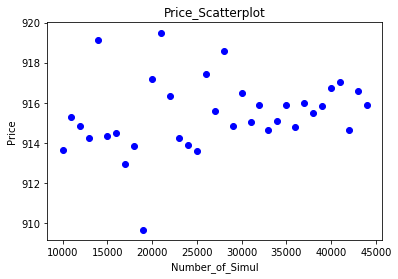

In [24]:
plt.scatter(x =np.arange(10000,45000,1000) ,y =  pd.DataFrame(list(price_lst), index = np.arange(10000,45000,1000)) , label = 'price' , color = 'blue')
plt.title('Price_Scatterplot')
plt.xlabel('Number_of_Simul')
plt.ylabel('Price')
plt.show()

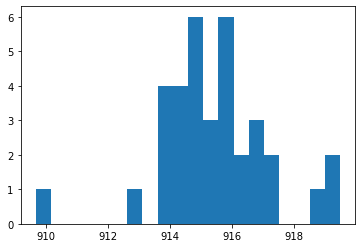

In [25]:
plt.hist(price_lst,bins = 20)
plt.show()

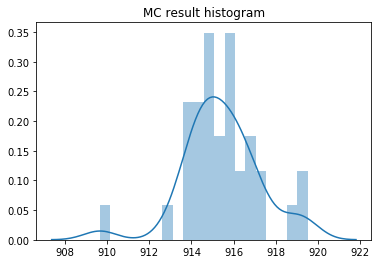

In [26]:
sns.distplot(price_lst,bins = 20)
plt.title('MC result histogram')
plt.show()

In [28]:
pd.Series(price_lst).std()

1.8295489738369046